# Análise de Churn

Vou criar um modelo de análise de Churn de um banco da região sul do Brasil. Serão buscadas possíveis tendências, desvios, padrões de comportamento e outros insights que favoreçam ao negócio, tanto na tomada de medidas para redução dos cancelamentos quanto no aumento da receita.

## Objetivo

O objetivo principal do modelo será prever os clientes com maior probabilidade de deixar o banco, para que hajam ações de contorno com esses clientes e o cancelamento possa ser revertido, senão, remediado.

## Limpeza e tratamento de dados

Vou utilizar os critérios abaixo na limpeza dos dados, onde buscarei validar e corrigir possíveis duplicidades, inconsistências, incompletudes e inconformidades nos dados.
Com isso, vou garantir a integridade dos dados para criar um modelo com o mínimo enviesamento possível a partir da base disponível.

### 1.0 Importando bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
import statistics as sts

A biblioteca **pandas** será importada para tratar os dados de forma tabular, como um DataFrame (df).

A biblioteca **seaborn** será importada para a visualização dos dados na etapa de exploração dos dados limpos.

A biblioteca **statistics** será importada para alguns cálculos de distribuição e detecção de outliers.

### 1.1 Compreendendo o dataset

Para compreender o dataset, primeiramente preciso importá-lo, verificar tamanho e atributos. A partir daí, posso iniciar o tratamento das inconsistências encontradas. 

In [2]:
# O dataset será importado e lido pelo Pandas como um DataFrame, a nomenclatura será df.
df = pd.read_csv("Churn.csv", sep=";")
# Visualização dos dados importados
df.head()

,X0,X1,X2,X3,X4,X4.1,X6,X7,X8,X9,X10,X11
0,1,619,RS,Feminino,42,2,0,1,1,1,10134888.0,1
1,2,608,SC,Feminino,41,1,8380786,1,0,1,11254258.0,0
2,3,502,RS,Feminino,42,8,1596608,3,1,0,11393157.0,1
3,4,699,RS,Feminino,39,1,0,2,0,0,9382663.0,0
4,5,850,SC,Feminino,43,2,12551082,1,1,1,790841.0,0


As colunas possuem nomes que não fazem sentido. Antes de analisar e tratar isso, quero entender o tamanho do dataset (linhas x colunas):

In [3]:
df.shape

(999, 12)

O dataset tem 999 linhas e 12 colunas.

### 1.2 Dicionário dos dados

O banco forneceu o dicionário das colunas, :
- id: Código de identificação de cada cliente.
- score: Pontuação do cliente no sistema de crédito do banco, quanto maior, melhor.
- estado: Estado (UF) da agência do cliente.
- genero: Gênero do cliente (feminino, masculino).
- idade: Idade do cliente.
- patrimonio: Quantidade de patrimônios declarados pelo cliente.
- saldo: Saldo na conta do cliente.
- produtos: Produtos do banco adquiridos ou assinados pelo cliente.
- temcartcredito: Possui cartão de crédito do banco (1 = sim, 0 = não).
- ativo: Conta ativa no banco (1 = sim, 0 = não).
- salario: Salário mensal do cliente, recebido no banco.
- excliente: Cliente cancelou a conta (churn) (1 = sim, 0 = não).

In [4]:
df.columns = ["id","score","estado",'genero','idade','patrimonio','saldo','produtos','temcartcredito','ativo','salario','excliente']
df.head()

,id,score,estado,genero,idade,patrimonio,saldo,produtos,temcartcredito,ativo,salario,excliente
0,1,619,RS,Feminino,42,2,0,1,1,1,10134888.0,1
1,2,608,SC,Feminino,41,1,8380786,1,0,1,11254258.0,0
2,3,502,RS,Feminino,42,8,1596608,3,1,0,11393157.0,1
3,4,699,RS,Feminino,39,1,0,2,0,0,9382663.0,0
4,5,850,SC,Feminino,43,2,12551082,1,1,1,790841.0,0


Antes de continuar a limpeza, é preciso compreender qual o tipo de dado de cada coluna, para posteriormente tratar de forma separada os dados categóricos e numéricos.
Para isso, será retornado o valor info() de todas as colunas.

### 1.3 Exploração dos dados

Agora, vou avaliar as principais informações sobre os dados, desde os tipos, classes e possíveis problemas que vão exigir limpeza e tratamento. Este processo de conhecer e explorar os dados com os quais vou lidar, pode ser subestimado, porém, é de grande relevância e evitará muitos problemas futuros.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              999 non-null    int64  
 1   score           999 non-null    int64  
 2   estado          999 non-null    object 
 3   genero          991 non-null    object 
 4   idade           999 non-null    int64  
 5   patrimonio      999 non-null    int64  
 6   saldo           999 non-null    int64  
 7   produtos        999 non-null    int64  
 8   temcartcredito  999 non-null    int64  
 9   ativo           999 non-null    int64  
 10  salario         992 non-null    float64
 11  excliente       999 non-null    int64  
dtypes: float64(1), int64(9), object(2)
memory usage: 93.8+ KB


Com as informações de classificação das colunas, a utilização dos dados será mais proveitosa desde a limpeza.

**Colunas categóricas:** estado, genero.

**Colunas numéricas:** id, score, idade, patrimonio, saldo, produtos, temcartcredito, ativo, salario, excliente.

Todas as colunas numéricas têm propriedade _int64_(números inteiros), exceto a coluna salario, que possui valor _float64_(número decimal). Posteriormente isso será tratado.

O tratamento será iniciado com as colunas categóricas.

estado
PR    257
RP      1
RS    478
SC    258
SP      4
TD      1
dtype: int64


<Axes: xlabel='estado'>

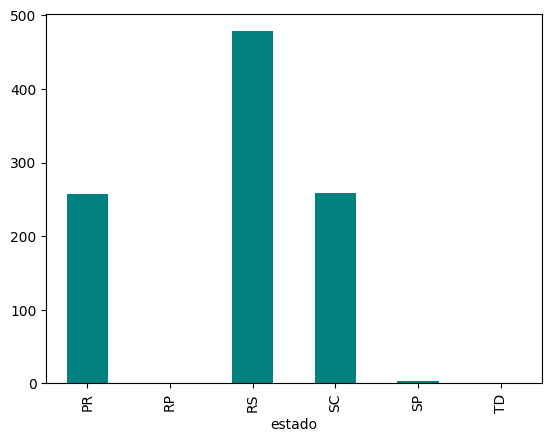

In [6]:
# Agrupamento dos dados da coluna estado:
estado = df.groupby(['estado']).size()
# Totais
print(estado)
# Visualização gráfica
estado.plot.bar(color='teal')

O primeiro problema encontrado é a **inconformidade** dos dados, pois "PR" (Paraná) aparentemente foi inserido errado pelo usuário na captação desse dado "RP". Além disso, a **integridade** também foi ferida, afinal, o estado TD não existe e o estado SP (São Paulo) não fica na região Sul do Brasil, mas sim no Sudeste.

Agora, o mesmo processo será realizado com a coluna _genero_:

genero
F              2
Fem            1
Feminino     461
M              6
Masculino    521
dtype: int64


<Axes: xlabel='genero'>

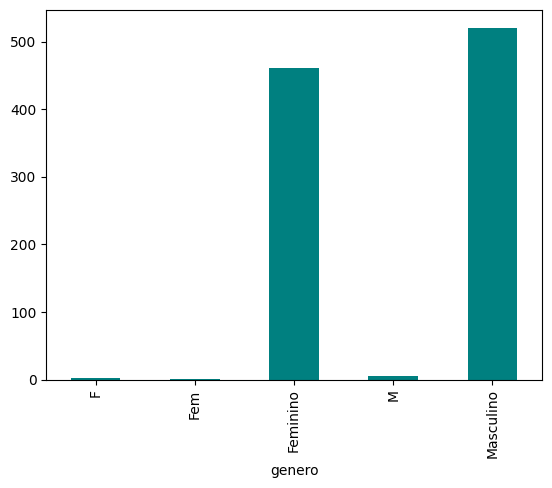

In [7]:
# Agrupamento dos dados da coluna genero:
genero = df.groupby(['genero']).size()
# Totais
print(genero)
# Visualização gráfica
genero.plot.bar(color='teal')

Também há inconformidade no preenchimento dos gêneros, "Feminino", "F" e "Fem" terão o mesmo valor para o modelo, assim como "M" e "Masculino". Isso também será tratado posteriormente.

Agora, vou verificar as colunas numéricas:

In [8]:
# Descrição
df['score'].describe()

count    999.000000
mean     648.621622
std       98.264219
min      376.000000
25%      580.000000
50%      653.000000
75%      721.000000
max      850.000000
Name: score, dtype: float64

- Não há nenhum score negativo, portanto, nenhuma entrada errada deste tipo foi capturada pelo banco.
- A menor pontuação existente é 376 pontos, a maior, 850 pontos.
- Tratando-se de muitos dados, quanto mais próximos os valores de média e mediana, menor a probabilidade de outliers no dataset. Isso não vale para este dataset pela quantidade bastante limitada de dados.

**Observação!**

Q1, Q2 e Q3 se referem a quartil 1, quartil 2 e quartil 3, que correspondem, respectivamente, a 25%, 50% e 75% do conjunto de dados.

_Um quartil é qualquer um dos três valores que divide o conjunto de dados em quatro partes iguais, e assim cada parte representa 1/4 da amostra ou população._

<Axes: xlabel='score'>

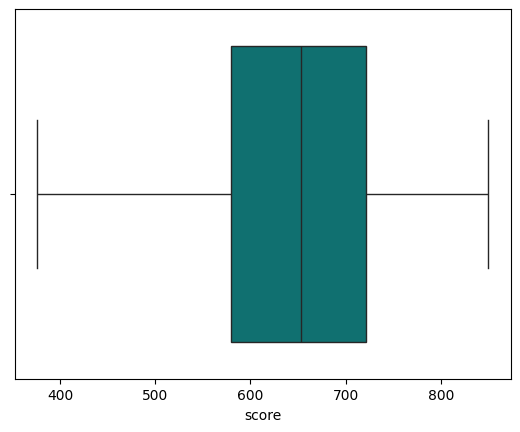

In [9]:
# Visualização gráfica
sns.boxplot(df['score'], color = 'teal', orient='h')

- A média (mean - average) é 648 pontos.
- A mediana (50%) é 653 pontos.
- Q1 = 376 <> 580
- Q2 = 581 <> 653
- Q3 = 654 <> 721

<Axes: xlabel='score', ylabel='Count'>

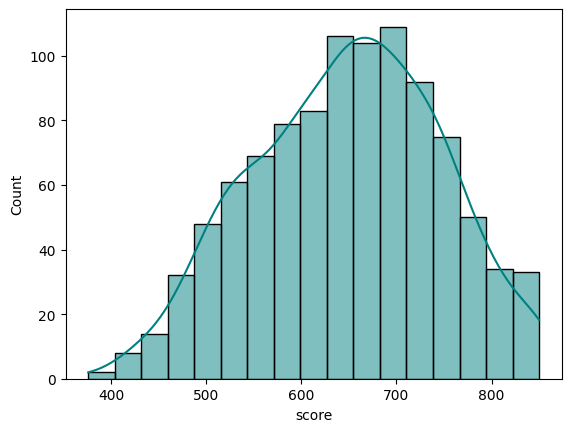

In [10]:
sns.histplot(df['score'], color = 'teal', kde=True)

- Há uma distribuição regular entre os dados, pois nenhuma anomalia foi observada.

Agora, vou visualizar as informações da coluna idade:

In [11]:
# Descrição
df['idade'].describe()

count    999.000000
mean      38.902903
std       11.401912
min      -20.000000
25%       32.000000
50%       37.000000
75%       44.000000
max      140.000000
Name: idade, dtype: float64

Vamos presumir que a idade deve variar entre 0 e 120.

- Considerando que 0<idade<120, existem diversos outliers que precisarão ser tratados.

<Axes: xlabel='idade'>

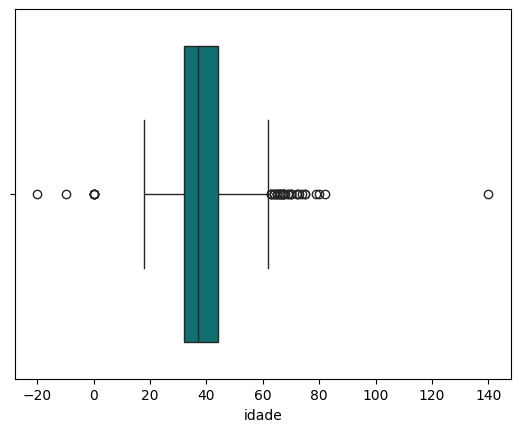

In [12]:
# Visualização gráfica
sns.boxplot(df['idade'], color = 'teal', orient='h')

- Com o bloxplot, é notável a presença de inconformidades que precisarão ser analisadas e corrigidas.

<Axes: xlabel='idade', ylabel='Count'>

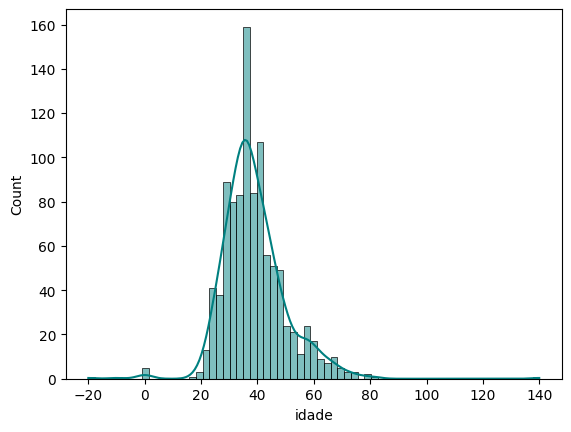

In [13]:
sns.histplot(df['idade'], color = 'teal', kde=True)

- Apesar dos outliers, a distribuição das idades não foge da normalidade nas faixas entre 18 e 80 anos.

Agora, o processo será repetido para a coluna saldo:

In [14]:
# Descrição
df['saldo'].describe()

count    9.990000e+02
mean     7.164928e+06
std      6.311840e+06
min      0.000000e+00
25%      0.000000e+00
50%      8.958835e+06
75%      1.258684e+07
max      2.117743e+07
Name: saldo, dtype: float64

- Muitos clientes com saldo 0, essa anomalia precisará ser investigada.

<Axes: xlabel='saldo'>

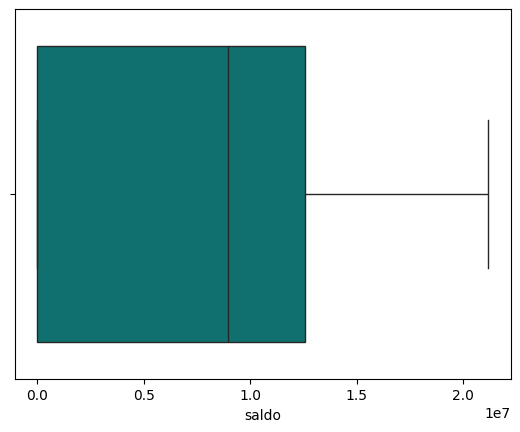

In [15]:
# Visualização gráfica
sns.boxplot(df['saldo'], color = 'teal', orient='h')

- O boxplot não revelou muita informação além da já conhecida com a descrição, a distribuição poderá trazer mais informações a respeito desses dados.

<Axes: xlabel='saldo', ylabel='Count'>

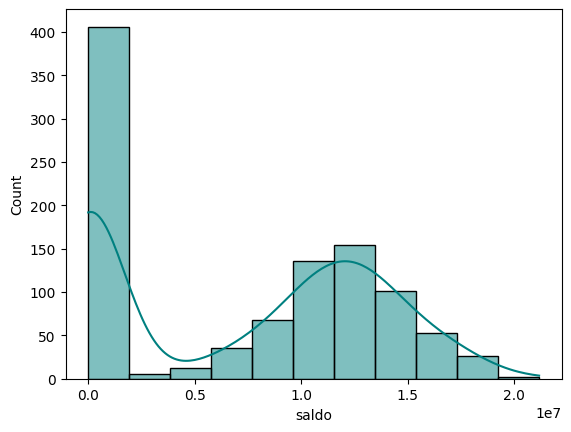

In [16]:
sns.histplot(df['saldo'], color = 'teal', kde=True)

- Com a distribuição, é nítida a concentração de clientes com saldo 0, podendo ser um fato consumado (muitos clientes com o saldo zerado, contas sem movimentação) ou então, tratar-se de um erro na coleta da informação, como "saldo não informado" = 0. Isso será investigado.

Agora, na coluna salario:

In [17]:
# Descrição
df['salario'].describe()

count    9.920000e+02
mean     3.528762e+07
std      5.305800e+08
min      9.677000e+03
25%      3.029011e+06
50%      8.703250e+06
75%      1.405213e+07
max      1.193469e+10
Name: salario, dtype: float64

- Os valores apresentados estão em formato científico pois são números com muitas casas decimais, a coluna é do tipo _float_.
- A média está muito distante da mediana, indicando (mesmo em um dataset com poucos dados) a possível presença de outliers.

Vou verificar com a visualização gráfica.

<Axes: xlabel='salario'>

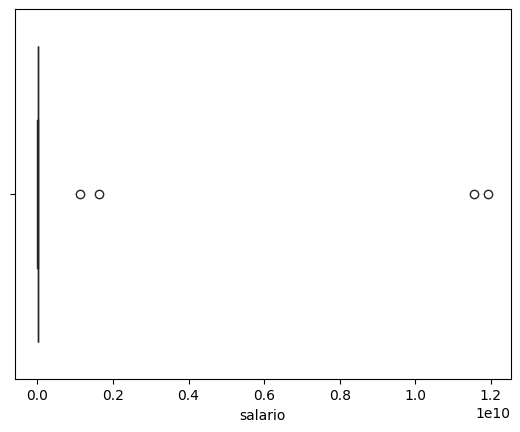

In [18]:
# Visualização gráfica
sns.boxplot(df['salario'], color = 'teal', orient='h')

- Fica claro que algo está incorreto quanto aos dados de salário, uma vez que, nem mesmo os quartis foram criados na figura. Os dados de salário precisam ser melhor analisados.

<Axes: xlabel='salario', ylabel='Count'>

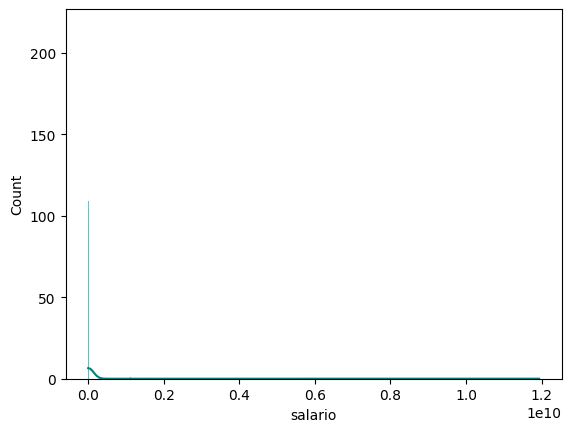

In [19]:
sns.histplot(df['salario'], color = 'teal', kde=True)

- A distribuição não mostra muita informação relevante com este formato de gráfico, uma vez que, pode haver uma grande quantidade de salários incorretos, porém, ainda não visualizados na análise.

Para resolver isso, tentarei identificar se os valores estão nulos.

In [20]:
df.isnull().sum()

id                0
score             0
estado            0
genero            8
idade             0
patrimonio        0
saldo             0
produtos          0
temcartcredito    0
ativo             0
salario           7
excliente         0
dtype: int64

- Existem 8 valores nulos na coluna 'genero' e 7 na coluna 'salario'. Nenhuma outra coluna possui nulos no dataset.

### Tratamento dos dados

Para o tratamento, poderei tanto eliminar quanto substituir valores incorretos ou nulos. Por padrão, quando for necessária a substituição dos dados nulos por algum valor, estarei usando a **mediana** como parâmetro. Para as colunas categóricas, utilizarei a **moda** como parâmetro, isto é, o termo com maior repetição no conjunto de dados.

numericos.fillna(mediana)
categoricos.fillna(moda)

Vou iniciar pela mesma ordem na qual explorei os dados anteriormente:
- estado
- gênero
- score
- idade
- saldo
- salario

Somente colunas numéricas podem ser calculadas, portanto, colunas categóricas não terão medianas.

In [21]:
# Definir a medianas:
med_idade = sts.median(df['idade'])
print(f'mediana idade = {med_idade}' )
med_patrimonio = sts.median(df['patrimonio'])
print(f'mediana patrimônio = {med_patrimonio}' )
med_saldo = sts.median(df['saldo'])
print(f'mediana saldo = {med_saldo}' )
med_produtos = sts.median(df['produtos'])
print(f'mediana produtos = {med_produtos}' )
med_temcartcredito = sts.median(df['temcartcredito'])
print(f'mediana temcartcredito = {med_temcartcredito}' )
med_ativo = sts.median(df['ativo'])
print(f'mediana ativo = {med_ativo}' )
med_salario = sts.median(df['salario'])
print(f'mediana salário = {med_salario}' )
med_excliente = sts.median(df['excliente'])
print(f'mediana excliente = {med_excliente}' )

mediana idade = 37
mediana patrimônio = 5
mediana saldo = 8958835
mediana produtos = 1
mediana temcartcredito = 1
mediana ativo = 1
mediana salário = 70518.0
mediana excliente = 0


Com as medianas definidas, posso substituir os valores das colunas com valores nulos:

In [22]:
# Primeiramente, farei uma cópia para salvar os dados limpos até o momento.
df_copy = df.copy()

# Agora, a substituição:
df['salario'] = df['salario'].fillna(med_salario)

In [23]:
# Visualização dos valores nulos, para confirmar a mudança:

df['salario'].isnull().sum()

np.int64(0)

Com o salário resolvido, agora, trabalharei na coluna genero.

In [24]:
# Agrupamento dos dados da coluna genero:
genero = df.groupby(['genero']).size()
# Totais
print(genero)

genero
F              2
Fem            1
Feminino     461
M              6
Masculino    521
dtype: int64


In [25]:
# Visualização dos valores nulos
df['genero'].isnull().sum()

np.int64(8)

Para a correção do NAs da coluna genero, utilizarei o atributo 'Masculino', que se repete 521 vezes, a moda do modelo.

In [26]:
df['genero'] = df['genero'].fillna('Masculino')

In [27]:
# Visualização dos valores nulos
df['genero'].isnull().sum()

np.int64(0)

Agora, vou fazer a padronização dos valores da variável de gênero. Valores como 'F' e 'Fem' serão transformados em 'Feminino', e 'M' será transformado em 'Masculino'.

Essa é uma correção de domínio, pois alguns valores estão inconsistentes ou fora do padrão esperado.

In [28]:
df.loc[df['genero'] == 'M','genero'] = 'Masculino' #Transformar M em Masculino
df.loc[df['genero'].isin(['Fem','F']), 'genero'] = 'Feminino' #Transformar F e Fem em Feminino

# Visualizar os dados agrupados
genero = df.groupby(['genero']).size()
# Totais
print(genero)

genero
Feminino     464
Masculino    535
dtype: int64


Agora, vou trabalhar na correção da idade, valores negativos e acima de 120.

In [29]:
# Criar um método de verificação da quantidade de valores fora da faixa 0<>120:
df.loc[(df['idade'] < 0) | (df['idade'] > 120)]

,id,score,estado,genero,idade,patrimonio,saldo,produtos,temcartcredito,ativo,salario,excliente
867,869,636,RS,Feminino,-10,1,17083346,1,1,0,11051028.0,1
984,986,773,RS,Masculino,-20,1,12453278,2,0,1,1172357.0,0
990,992,655,RS,Masculino,140,5,93147,2,1,0,6621413.0,0


Existem apenas 3 registros fora desses parâmetros, com idades negativas (-10 e -20) ou acima de 120 anos (140). A idade é um valor numérico, portanto, utilizarei a mediana para substituir os dados fora do padrão estabelecido.

In [30]:
# Substituir datas fora do padrão pela mediana da idade:
df.loc[(df['idade'] < 0) | (df['idade'] > 120)] = med_idade

# Visualizar os dados fora do padrão
df.loc[(df['idade'] < 0) | (df['idade'] > 120)]

,id,score,estado,genero,idade,patrimonio,saldo,produtos,temcartcredito,ativo,salario,excliente


Nenhum registro fora do padrão estipulado. Agora, vou verificar os dados duplicados no dataset.

In [31]:
df[df.duplicated(['id'], keep=False)]

,id,score,estado,genero,idade,patrimonio,saldo,produtos,temcartcredito,ativo,salario,excliente
36,37,490,SC,Masculino,31,3,14526023,1,0,1,11406677.0,0
80,81,665,RS,Feminino,34,1,9664554,2,0,0,17141366.0,0
81,81,665,RS,Feminino,34,1,9664554,2,0,0,17141366.0,0
867,37,37,37,37,37,37,37,37,37,37,37.0,37
984,37,37,37,37,37,37,37,37,37,37,37.0,37
990,37,37,37,37,37,37,37,37,37,37,37.0,37


Dois clientes têm dados duplicados, 37 e 81. Portanto, vou eliminar os dados duplicados dos dois clientes, mantendo apenas o primeiro valor (indexado) de cada cliente.

In [32]:
# Remover valores duplicados mantendo apenas o primeiro registro:
df.drop_duplicates(subset='id',keep='first',inplace=True)

# Visualizar dados duplicados:
df[df.duplicated(['id'], keep=False)]

,id,score,estado,genero,idade,patrimonio,saldo,produtos,temcartcredito,ativo,salario,excliente


Com os duplicados resolvidos, vou resolver outro problema de inconsistência de domínio, os Estados.

In [33]:
# Visualizar os dados agrupados
estado = df.groupby(['estado']).size()
# Totais
print(estado)

estado
PR    257
RP      1
RS    474
SC    258
SP      4
TD      1
dtype: int64


Assim como a coluna 'genero', a coluna 'estado' é categórica, portanto, os dados inconsistentes serão alterados para a moda, que neste contexto é o valor 'RS' (474 repetições).

In [34]:
# Vou alterar os valores "RP", "SP" e "TD" para "RS":
df.loc[df['estado'].isin(['RP', 'SP', 'TD']), 'estado'] = 'RS'
# Visualizar os dados agrupados
estado = df.groupby(['estado']).size()
# Totais
print(estado)

estado
PR    257
RS    480
SC    258
dtype: int64


Por fim, os outliers serão verificados, pois aparentemente existem outliers. Para realizar o tratamento, vou analisar o desvio padrão da coluna salário. Valores que estiverem 2 desvios acima da média, serão considerados outliers.

Para isso, primeiramente vou calcular o desvio padrão dos salários:

In [35]:
dp_salario = sts.stdev(df['salario'])
print(f'O desvio padrão dos salários é: {dp_salario}')

O desvio padrão dos salários é: 529784177.60963464


In [36]:
df.loc[df['salario'] >= 2 * dp_salario]

,id,score,estado,genero,idade,patrimonio,saldo,produtos,temcartcredito,ativo,salario,excliente
7,8,376,PR,Feminino,29,4,11504674,4,1,0,1.193469e+10,1
116,118,668,PR,Feminino,37,6,1678644,1,1,0,1.156383e+10,0
170,172,484,RS,Feminino,29,4,13011439,1,1,0,1.640179e+09,0
230,232,673,RS,Masculino,72,1,0,2,0,1,1.119812e+09,0


Uma assunção estatística implícita Gaussiana indica que, caso haja uma distribuição normal, 68% dos dados estarão dentro de ±1 desvio padrão da média, 95% dentro de ±2 desvios, e o restante fora de ±2 desvios. Neste caso, pressupõe-se tratar os outliers com essa abordagem (se ± 2 desvios = outlier).

Porém, esse processo pressupõe uma distribuição normal entre os dados, o que não é o caso desse dataset, pois os dados estão enormemente mal distribuídos.

In [37]:
maxi = df['salario'].max()
mini = df['salario'].min()
media = df['salario'].mean()

print(maxi)
print(mini)
print(media)

11934688000.0
9677.0
35145554.52361809


In [38]:
print(df['salario'].sort_values(ascending=False).head(200))

7      1.193469e+10
116    1.156383e+10
170    1.640179e+09
230    1.119812e+09
118    1.997254e+07
           ...     
804    1.517385e+07
682    1.513035e+07
720    1.506944e+07
293    1.504015e+07
484    1.502278e+07
Name: salario, Length: 200, dtype: float64


In [39]:
df['salario'] = df['salario'].astype(int)

In [40]:
dp_salario = sts.stdev(df['salario'])
print(f'O desvio padrão dos salários é: {dp_salario}')

O desvio padrão dos salários é: 529784177.60963464


In [41]:
print(df['salario'].sort_values(ascending=False).head(200))

7      11934688000
116    11563829000
170     1640178900
230     1119811900
118       19972539
          ...     
804       15173854
682       15130348
720       15069442
293       15040153
484       15022785
Name: salario, Length: 200, dtype: int64


In [42]:
df.loc[df['salario'] >= 2 * dp_salario, 'salario'] = med_salario

<Axes: xlabel='salario'>

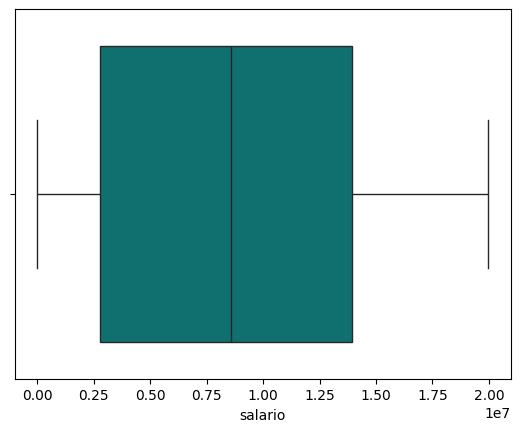

In [43]:
# Visualização gráfica
sns.boxplot(df['salario'], color = 'teal', orient='h')

<Axes: xlabel='salario', ylabel='Count'>

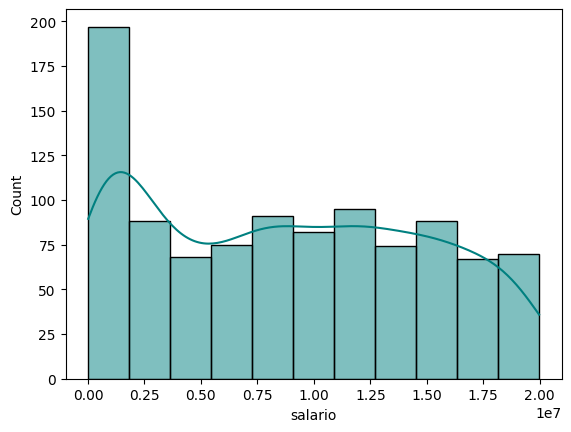

In [44]:
sns.histplot(df['salario'], color = 'teal', kde=True)